# **Credit Card Fraud Detection**


Nous allons utiliser le jeu de données [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud), qui recense les transactions effectuées par des titulaires de cartes européennes. Ce jeu de données comprend 284 807 transactions, dont 492 sont frauduleuses. Les informations qu'il contient sont constituées uniquement de variables numériques, obtenues par des transformations d'Analyse en Composantes Principales (ACP) afin de respecter la confidentialité des données. Les caractéristiques sont constituées des colonnes 'Time', 'Amount' et 'V1' à 'V28', ainsi que la variable 'Class', qui sert de cible et indique si la transaction est frauduleuse (1) ou non (0).

Dans le cadre de ce projet, nous débuterons par une analyse exploratoire des données (EDA) afin de mieux appréhender les informations présentes. Ensuite, nous procéderons au traitement des données et à la modélisation en construisant différents modèles de classification pour prédire les transactions frauduleuses. La problématique des classes déséquilibrées sera prise en compte grâce à une approche d'échantillonnage. Enfin, nous évaluerons les performances des modèles et sélectionnerons le meilleur en fonction de diverses mesures d'évaluation telles que la précision, le rappel, le score F1 et l'exactitude.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, accuracy_score

# 1. EDA

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


La variable Target: Class ( 1 pour fraude et 0 sinon)
2 variables qu'on peur pas transformer: Amount et Time

<AxesSubplot:title={'center':'Time Distribution (Seconds)'}, xlabel='Time', ylabel='Count'>

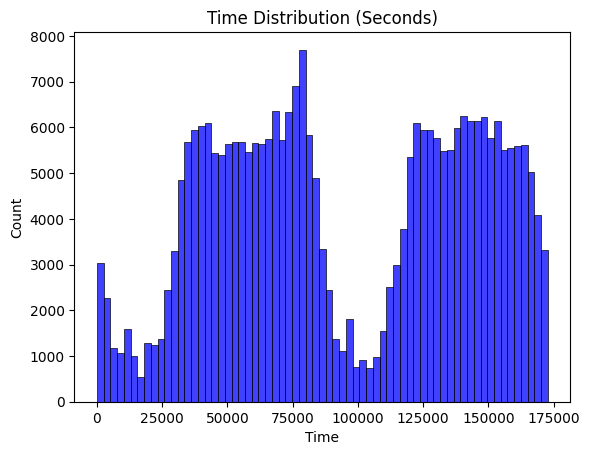

In [3]:
plt.figure()
plt.title('Time Distribution (Seconds)')
sns.histplot(df['Time'], color='blue')

D'après le graphique, nous pouvons observer que la variable "Time" présente une distribution avec deux pics, indiquant qu'il y a deux périodes dans la journée où les transactions par carte de crédit sont plus fréquentes et une potentielle corrélation avec la variable Target.

In [4]:
fraud = df['Class'].value_counts()[1]
nonfraud = df['Class'].value_counts()[0]
print(f'Fraudulent: {fraud}, Non-fraudulent: {nonfraud}')
print(f'Ratio of fraud to non-fraud: {fraud}/{nonfraud} ({fraud/nonfraud*100:.3f}%)')

Fraudulent: 492, Non-fraudulent: 284315
Ratio of fraud to non-fraud: 492/284315 (0.173%)


Text(0.5, 0, '0:Non-Fraudulent, 1:Fraudulent')

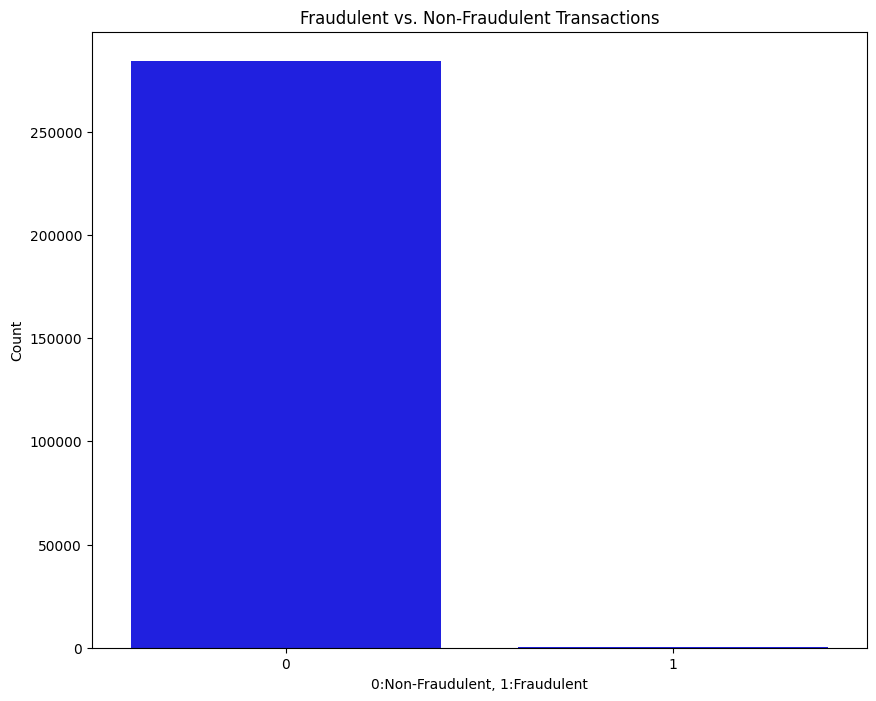

In [5]:
plt.figure(figsize=(10,8))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts(), color='blue')
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('0:Non-Fraudulent, 1:Fraudulent')

Les cas fraudulents représentent 0.173% du total du jeu de données, ce qui montre un fort déséquilibre des données qu'on peut régler en utilisant des techniques d'oversampling ou d'undersampling.

# 2. Data Processing

D'après la heatmap ci-dessout on peut observer qu'il n'y a pas de fortes corrélations positives ou négatives entre les différentes paires de variables du jeu de données. Les corrélations les plus marquées sont les suivantes :

- Entre "Time" et "V3", avec un coefficient de corrélation de -0.42.
- Entre "Amount" et "V2", avec un coefficient de corrélation de -0.53.
- Entre "Amount" et "V4", avec un coefficient de corrélation de 0.4.

Bien que ces corrélations soient relativement élevées, le risque de multicolinéarité n'est pas considéré comme significatif. Dans l'ensemble, le diagramme de corrélation suggère qu'il n'y a pas de variables fortement corrélées qui doivent être supprimées avant de construire un modèle d'apprentissage automatique.

<AxesSubplot:>

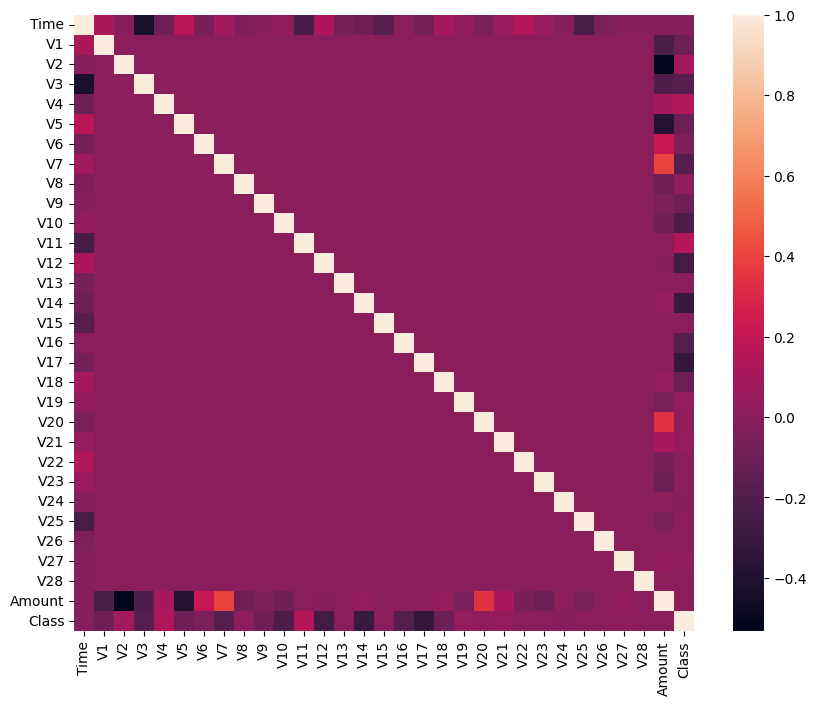

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr())

# 3. Modeling
✅ Le jeu de données "Credit Card Fraud Detection" contient des transactions de cartes de crédit étiquetées comme frauduleuses ou non. Le jeu de données étant déséquilibré, il a besoin d'un modèle capable de détecter avec précision les transactions frauduleuses sans signaler à tort des transactions non frauduleuses.

✅ Pour aider à résoudre les problèmes de classification, le StandardScaler standardise les données en leur donnant une moyenne de 0 et un écart-type de 1, ce qui résulte en une distribution normale. Cette technique fonctionne bien lorsqu'on traite une large gamme de montants et de temps. Pour mettre à l'échelle les données, l'ensemble d'entraînement est utilisé pour initialiser l'ajustement, et les ensembles d'entraînement, de validation et de test sont ensuite mis à l'échelle avant de les introduire dans les modèles.

✅ Le jeu de données a été divisé en 60 % pour l'entraînement, 20 % pour la validation et 20 % pour les tests. Pour équilibrer le jeu de données déséquilibré, la technique de Random Undersampling a été utilisée pour égaliser le nombre de transactions frauduleuses. Des modèles de régression logistique et de forêt aléatoire ont été utilisés, et de bons résultats ont été obtenus.

✅ Les modèles couramment utilisés pour le jeu de données "Détection de Fraude par Carte de Crédit" sont la régression logistique, le Naive Bayes, la forêt aléatoire et le classificateur Dummy.

*    **Logistic Regression** est largement utilisée pour la détection de fraude en raison de son interprétabilité et de sa capacité à traiter de grands ensembles de données.
*    **Naive Bayes** est couramment utilisé pour la détection de fraude car il peut gérer des ensembles de données avec un grand nombre de fonctionnalités et peut fournir des prédictions rapides.
*    **Random Forest** est couramment utilisée pour la détection de fraude car elle peut gérer des ensembles de données complexes et est moins sujette au overfitting.
 *   **Dummy Classifier** est un algorithme simple utilisé comme référence pour comparer les performances des autres modèles.

In [8]:
data = df.drop(columns=['Class'])
target = df['Class']

In [9]:
X_train, X_val, y_train, y_val = train_test_split(data, target
                                                          , test_size=0.2
                                                          , stratify=df['Class']
                                                          , random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

✅ Undersampling

In [10]:
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train_std, y_train)
X_val_under, y_val_under = rus.fit_resample(X_val_std, y_val)

## 3.1. Logistic Regression

In [11]:
penalty = ['l2']
C = np.logspace(0, 4, 10, 100, 1000)
param_grid = dict(C=C, penalty=penalty)
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train_under, y_train_under)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 2.15443469e+01, 4.64158883e+02, 1.00000000e+04,
       2.15443469e+05, 4.64158883e+06, 1.00000000e+08, 2.15443469e+09,
       4.64158883e+10, 1.00000000e+12]),
                         'penalty': ['l2']},
             scoring='roc_auc', verbose=10)

## 3.2. Naive Bayes

In [13]:
gnb = GaussianNB()
gnb_best = gnb.fit(X_train_under, y_train_under)

## 3.3. Random Forest

In [14]:
param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 700]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train_under,y_train_under)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': ['sqrt'],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [500, 700]},
             scoring='roc_auc', verbose=10)

## 3.4. Dummy Classifier

In [15]:
dummy = DummyClassifier()
dummy.fit(X_train_under, y_train_under)

DummyClassifier()

# 4. Model Evaluation

## 4.1. Score ROC



In [16]:
def plot_roc_curves(X, y, models, model_names, figsize=(20,18)):
    fig, ax = plt.subplots(figsize=figsize)

    for i, model in enumerate(models):
        y_pred = list(model.predict_proba(X)[:, 1])
        fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=(model_names[i] + ' AUC = %0.4f' % roc_auc), linewidth=2.0)

    ax.grid(False)
    ax.tick_params(length=6, width=2, labelsize=30, grid_color='r', grid_alpha=0.5)
    leg = plt.legend(loc='lower right', prop={'size': 25})
    leg.get_frame().set_edgecolor('b')
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=40)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('True Positive Rate', fontsize=30)
    plt.xlabel('False Positive Rate', fontsize=30)

In [17]:
models = [logistic_grid.best_estimator_, gnb_best, rf_grid.best_estimator_, dummy]
model_names = ['Logit', 'Naive Bayes', 'Random Forest', 'Dummy']

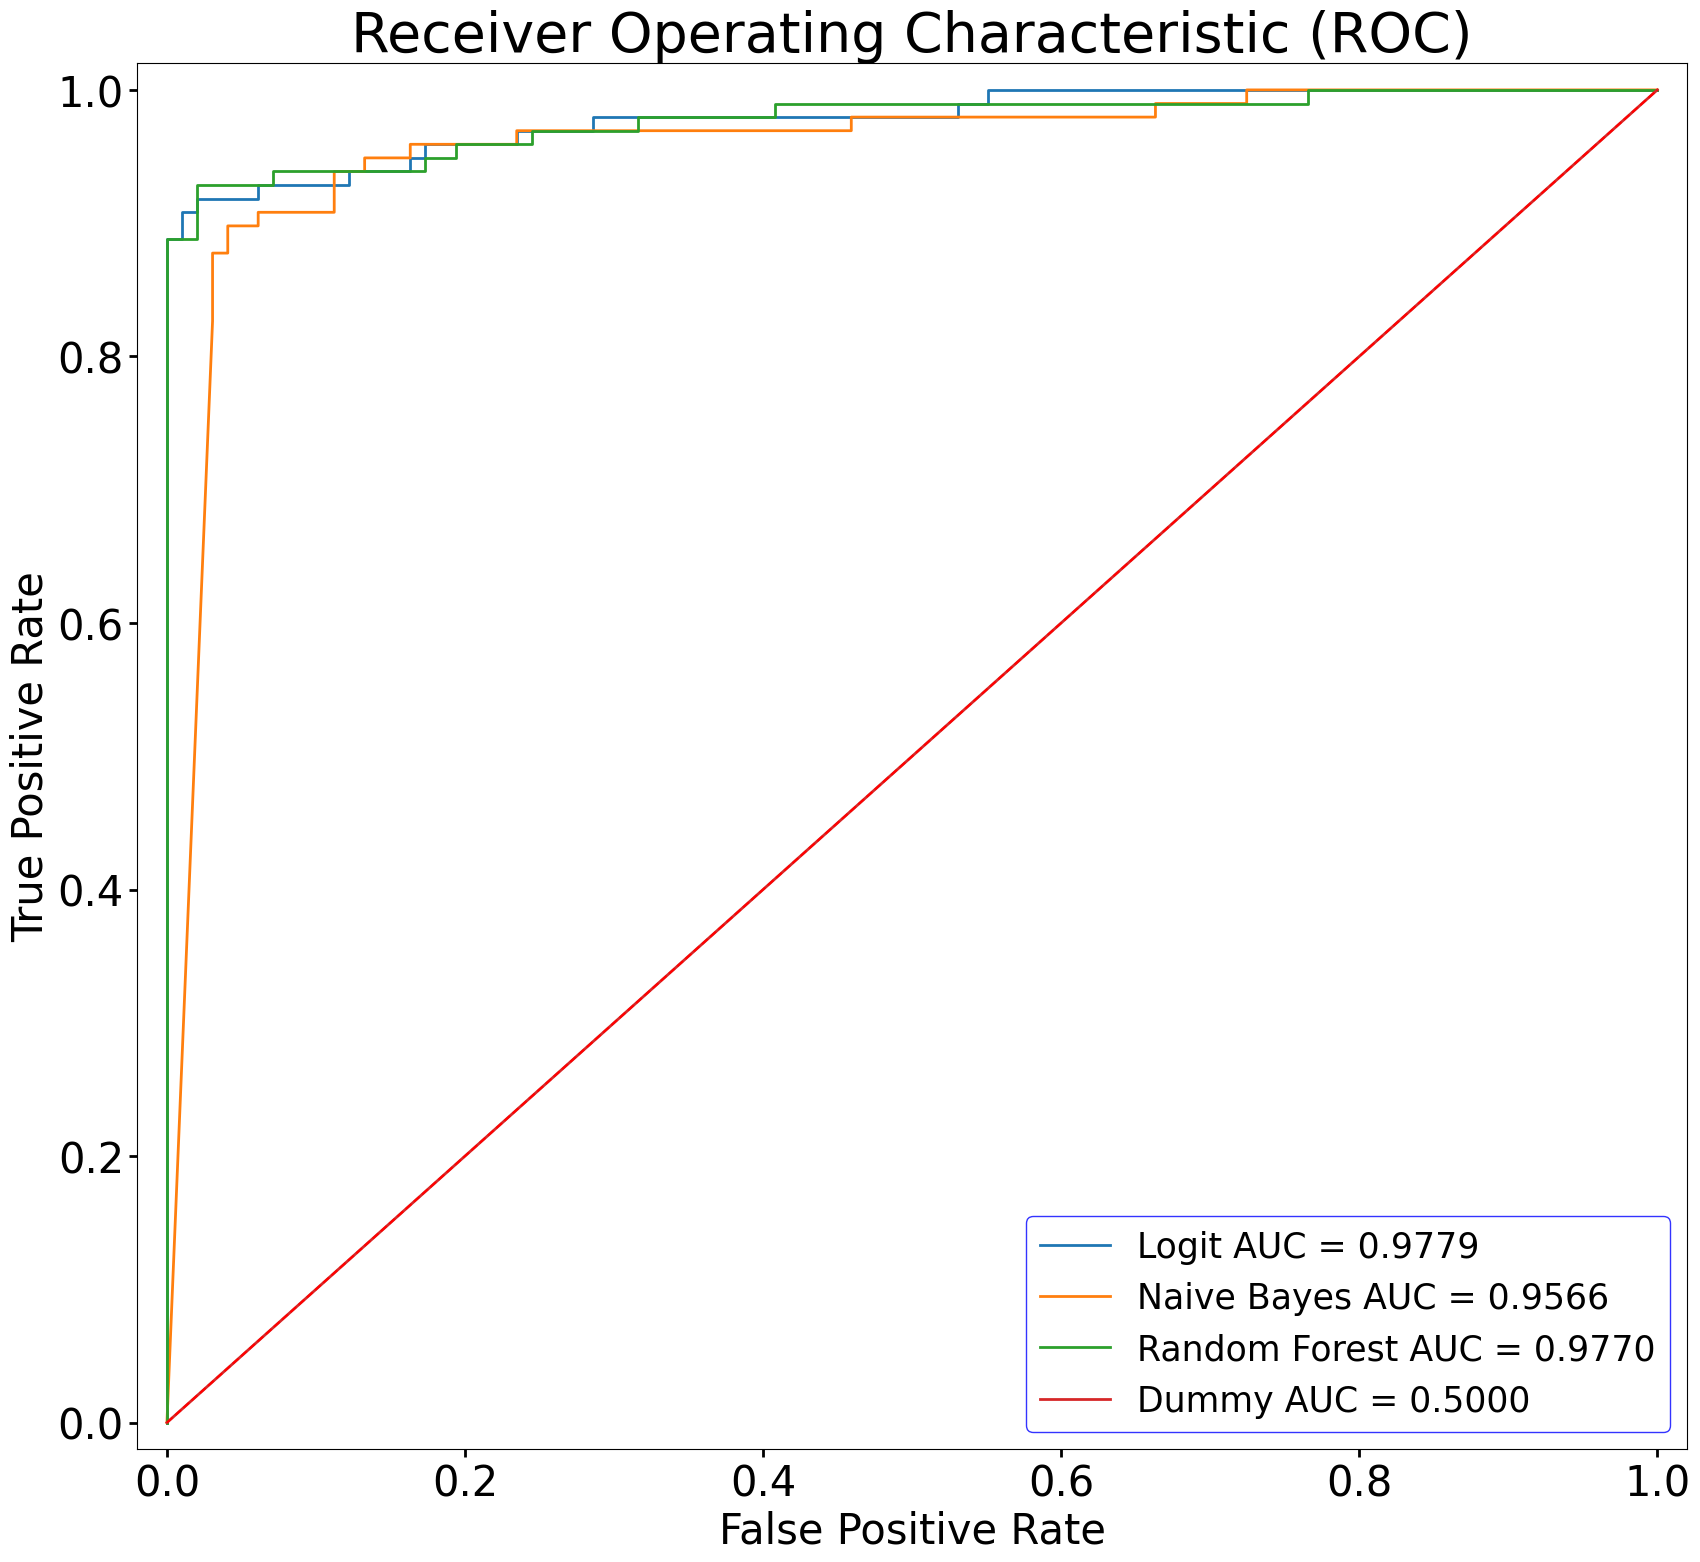

In [18]:
plot_roc_curves(X_val_under, y_val_under, models, model_names)

* Recall (Taux de vrais positifs) : Cette métrique mesure le pourcentage de toutes les transactions frauduleuses que le modèle identifie correctement comme frauduleuses.

* Précision : Cette métrique indique le pourcentage d'éléments que le modèle étiquette comme frauduleux et qui sont effectivement frauduleux.

* Taux de faux positifs : Cette métrique mesure le pourcentage de transactions non frauduleuses que le modèle étiquette à tort comme frauduleuses.

* Précision globale (Accuracy) : Cette métrique reflète à quelle fréquence le modèle est correct dans ses prédictions globales. Cependant, elle peut être trompeuse dans le cas de données déséquilibrées ou de détection de fraude.

* Score F1 : Cette métrique est une combinaison de la précision et du rappel, prenant en compte à la fois les faux positifs et les faux négatifs. C'est une moyenne pondérée de la précision et du rappel, et elle est généralement plus utile que l'exactitude, en particulier lorsqu'il s'agit de classes inégales.

## 4.2. Determine the optimal threshold for each model.

✅ La fonction "find_best_threshold()" peut être utilisée pour déterminer le seuil optimal pour un modèle donné. Le seuil optimal est la valeur qui maximise le score F1, une mesure qui combine la précision et le recall, pour un problème de classification binaire.

✅ La fonction prend deux arguments : "model" est le modèle entraîné et "num_steps" est le nombre d'étapes dans la plage de seuil à parcourir.

✅ La fonction initialise d'abord les variables pour le score F1 le plus élevé, le meilleur seuil et les meilleurs scores d'exactitude, de rappel et de précision. Ensuite, elle parcourt une plage de seuils de 0 à 1, avec "num_steps" étapes. Pour chaque seuil, elle prédit la variable cible en utilisant le seuil donné et calcule le score F1, l'exactitude, le rappel et la précision. Si le score F1 est supérieur au score F1 le plus élevé actuel, elle met à jour le meilleur seuil et les métriques d'évaluation.

✅ Après avoir parcouru tous les seuils, la fonction renvoie le meilleur seuil ainsi que les scores F1, d'exactitude, de rappel et de précision correspondants.

✅ L'équation mathématique pour trouver le score F1 est la suivante :

`F1 = 2 * (précision * recall) / (précision + recall)`

**où**
* précision = TP / (TP + FP)
* rappel = TP / (TP + FN)
* TP : Vrais Positifs (le modèle prédit positif et c'est positif)
* FP : Faux Positifs (le modèle prédit positif mais c'est négatif)
* FN : Faux Négatifs (le modèle prédit négatif mais c'est positif)

In [20]:
def find_best_threshold(model, num_steps):
    highest_f1 = 0
    best_threshold = 0
    best_acc = 0
    best_rec = 0
    best_pre = 0
    for threshold in np.linspace(0, 1, num_steps):
        y_predict = (model.predict_proba(X_val_under)[:, 1] >= threshold)
        f1 = f1_score(y_val_under, y_predict)
        acc = accuracy_score(y_val_under, y_predict)
        rec = recall_score(y_val_under, y_predict)
        pre = precision_score(y_val_under, y_predict)
        if f1 > highest_f1:
            best_threshold, highest_f1, best_acc, best_rec, best_pre = \
                threshold, f1, acc, rec, pre
    return best_threshold, highest_f1, best_acc, best_rec, best_pre

In [21]:
models = [logistic_grid, gnb_best, rf_grid]
model_names = ["Logistic Regression", "Naive-Bayes", "Random Forest"]

In [22]:
chart = list()

for item, name in zip(models, model_names):
    best_thresh, high_f1, high_acc, high_rec, high_pre = find_best_threshold(item, 20)
    chart.append([name, best_thresh, high_f1, high_acc, high_rec, high_pre])

chart = pd.DataFrame(chart, columns=['Model', 'Best Threshold', 'F1 Score', 'Accuracy', 'Recall', 'Precision'])
chart.to_csv('model_evaluation_scores.csv')
chart

,Model,Best Threshold,F1 Score,Accuracy,Recall,Precision
0,Logistic Regression,0.789474,0.947368,0.948980,0.918367,0.978261
1,Naive-Bayes,0.052632,0.919786,0.923469,0.877551,0.966292
2,Random Forest,0.368421,0.947917,0.948980,0.928571,0.968085


## 4.3. Confusion Matrix

In [23]:
def make_confusion_matrix_val(model, threshold=0.5):

    y_predict = (model.predict_proba(X_val_under)[:, 1] >= threshold)
    
    fraud_confusion = confusion_matrix(y_val_under, y_predict)
    
    plt.figure(dpi=100)
    sns.set(font_scale=1)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud']);
    
    TP = fraud_confusion[0][0]
    FP = fraud_confusion[0][1]
    FN = fraud_confusion[1][0]
    TN = fraud_confusion[1][1]
    
    plt.yticks(rotation = 0)
    
    plt.title('Predicted vs. Actual',fontname = '.SF Compact Display',fontsize = 20,pad = 10);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

findfont: Font family ['.SF Compact Display'] not found. Falling back to DejaVu Sans.


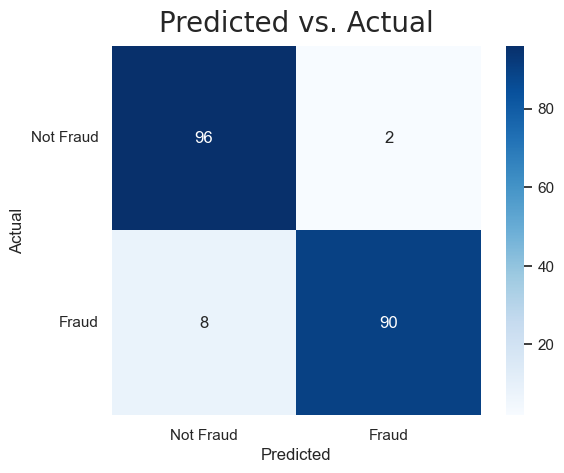

In [24]:
make_confusion_matrix_val(rf_grid, threshold=0.421)

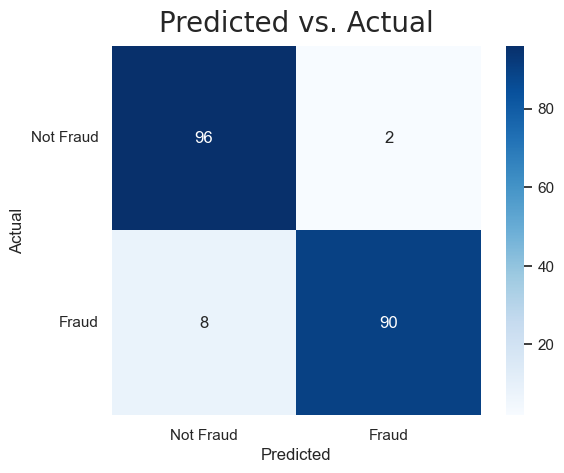

In [25]:
make_confusion_matrix_val(logistic_grid, threshold=0.842)